# Tutorial de Vector Embeddings

En este tutorial aprenderemos sobre vector embeddings, qué son, cómo funcionan y cómo podemos usarlos para encontrar similitudes entre textos.

In [1]:
# Instalación de dependencias
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
from dotenv import load_dotenv
import openai

## 1. Similitud de Coseno

La similitud de coseno es una medida que nos dice qué tan similares son dos vectores. Se calcula como el coseno del ángulo entre los vectores.

In [9]:
def cosine_similarity(v1, v2):
    """Calcula la similitud de coseno entre dos vectores."""
    # Convertir las listas a arrays de numpy si no lo son ya
    v1 = np.array(v1)
    v2 = np.array(v2)
    
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.sqrt(np.sum(v1**2))
    magnitude_v2 = np.sqrt(np.sum(v2**2))
    
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0
        
    return dot_product / (magnitude_v1 * magnitude_v2)

# Ejemplo de uso
v1 = np.array([1, 2, 3])
v2 = np.array([1, 2, 3])
v3 = np.array([-1, -2, -3])

print(f"Similitud entre v1 y v2: {cosine_similarity(v1, v2)}")
print(f"Similitud entre v1 y v3: {cosine_similarity(v1, v3)}")

Similitud entre v1 y v2: 1.0
Similitud entre v1 y v3: -1.0


## 2. Vector Embeddings con OpenAI

Ahora vamos a usar el modelo text-embedding-3-small de OpenAI para generar embeddings de texto.

In [5]:
# Configurar el cliente de OpenAI
load_dotenv(override=True)
openai_host = os.getenv("OPENAI_HOST", "openai")
model_name = os.getenv("OPENAI_MODEL", "gpt-4o")
# print(f"This is the key: {os.environ['OPENAI_KEY']}")
client = openai.OpenAI(
        api_key=os.environ["OPENAI_KEY"]
    )

print(f"Using model {model_name}")

Using model gpt-4o


In [6]:
def get_embedding(text):
    """Obtiene el embedding de un texto usando OpenAI."""
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return response.data[0].embedding

In [7]:
# Frases de ejemplo
frases = [
    "El Señor de los Anillos es una película de fantasía épica",
    "Star Wars es una saga de ciencia ficción",
    "El clima está muy agradable hoy",
    "La Guerra de las Galaxias es una película de ciencia ficción"
]

# Generar embeddings
embeddings = [get_embedding(frase) for frase in frases]

# Mostrar la dimensión de los embeddings
print(f"Dimensión de los embeddings: {len(embeddings[0])}")

Dimensión de los embeddings: 1536


## 3. Comparando similitudes

Vamos a comparar las similitudes entre las frases:

In [10]:
# Crear una matriz de similitud
similitudes = []
for i, emb1 in enumerate(embeddings):
    fila = []
    for j, emb2 in enumerate(embeddings):
        sim = cosine_similarity(emb1, emb2)
        fila.append(sim)
    similitudes.append(fila)

# Crear un DataFrame para visualizar mejor
df_similitudes = pd.DataFrame(similitudes, 
                            index=frases, 
                            columns=frases)

print("Matriz de similitud:")
df_similitudes

Matriz de similitud:


,El Señor de los Anillos es una película de fantasía épica,Star Wars es una saga de ciencia ficción,El clima está muy agradable hoy,La Guerra de las Galaxias es una película de ciencia ficción
El Señor de los Anillos es una película de fantasía épica,1.000000,0.473026,0.191296,0.477404
Star Wars es una saga de ciencia ficción,0.473026,1.000000,0.122197,0.749561
El clima está muy agradable hoy,0.191296,0.122197,1.000000,0.091572
La Guerra de las Galaxias es una película de ciencia ficción,0.477404,0.749561,0.091572,1.000000


## 4. Búsqueda de similitud

Vamos a crear una función que nos permita buscar las frases más similares a una consulta:

In [11]:
def buscar_similares(consulta, frases, embeddings, top_n=3):
    """Busca las frases más similares a la consulta."""
    # Obtener embedding de la consulta
    consulta_embedding = get_embedding(consulta)
    
    # Calcular similitudes
    similitudes = []
    for i, emb in enumerate(embeddings):
        sim = cosine_similarity(consulta_embedding, emb)
        similitudes.append((frases[i], sim))
    
    # Ordenar por similitud
    similitudes.sort(key=lambda x: x[1], reverse=True)
    
    # Retornar las top_n más similares
    return similitudes[:top_n]

In [12]:
# Ejemplo de búsqueda
consulta = "película de ciencia ficción"
resultados = buscar_similares(consulta, frases, embeddings)

print(f"Resultados para la consulta: '{consulta}'")
for frase, similitud in resultados:
    print(f"- {frase} (similitud: {similitud:.4f})")

Resultados para la consulta: 'película de ciencia ficción'
- La Guerra de las Galaxias es una película de ciencia ficción (similitud: 0.5913)
- Star Wars es una saga de ciencia ficción (similitud: 0.5157)
- El Señor de los Anillos es una película de fantasía épica (similitud: 0.4662)


## 5. Visualización de embeddings

Para visualizar los embeddings en 2D, podemos usar PCA (Principal Component Analysis):

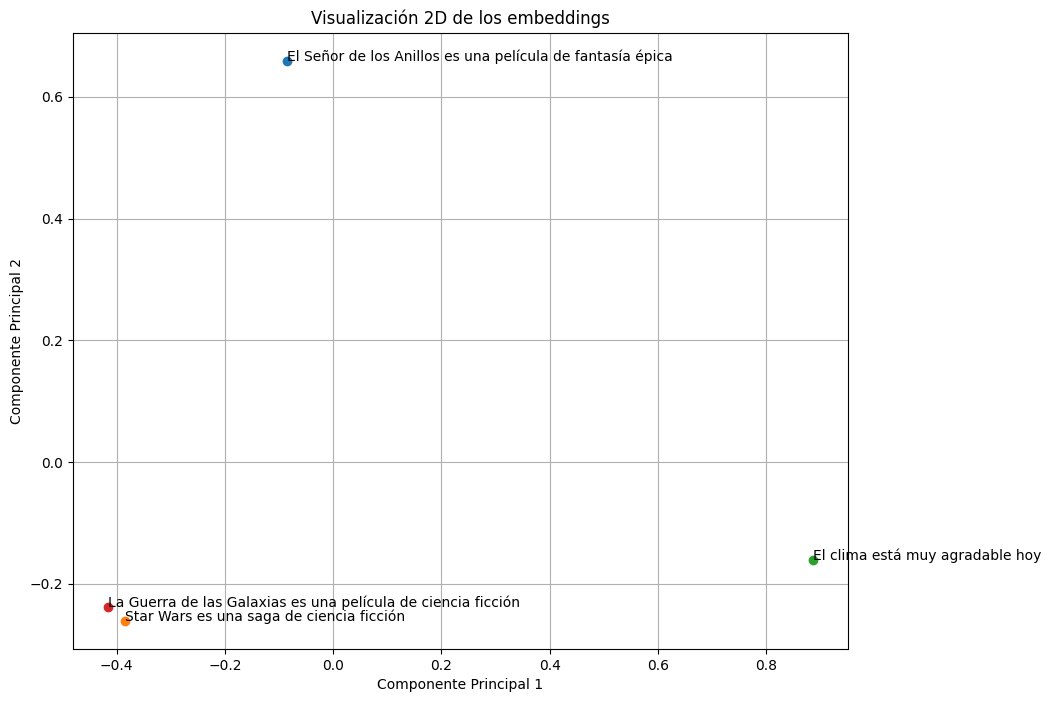

In [13]:
# Reducir a 2 dimensiones
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Crear el gráfico
plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(embeddings_2d):
    plt.scatter(x, y)
    plt.annotate(frases[i], (x, y))

plt.title('Visualización 2D de los embeddings')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

## Conclusión

En este tutorial hemos aprendido:

1. Qué son los vector embeddings y cómo se calcula la similitud entre ellos
2. Cómo generar embeddings usando el modelo text-embedding-3-small de OpenAI
3. Cómo comparar similitudes entre textos usando embeddings
4. Cómo buscar textos similares a una consulta
5. Cómo visualizar embeddings en 2D

Los vector embeddings son una herramienta poderosa para trabajar con texto, permitiéndonos encontrar similitudes semánticas entre documentos, realizar búsquedas semánticas y mucho más. 